In [1]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from operator import itemgetter

# Information spread

In [394]:
df = pd.read_csv('all_tweets.csv',sep=',')
df = df[df.date != '[]']

### Plot a quick histogram of sentiment for the tweets

In [395]:
df['date_day'] = pd.to_datetime(df['date']).dt.round('H')
df_date = df.groupby('date_day').agg({'id':'count'})
df_date.head()

,id
date_day,
2018-11-30 04:00:00,12
2018-11-30 05:00:00,4
2018-11-30 06:00:00,5
2018-11-30 07:00:00,15
2018-11-30 08:00:00,14


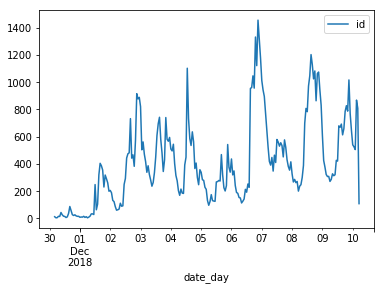

In [396]:
df_date.plot(kind='line')

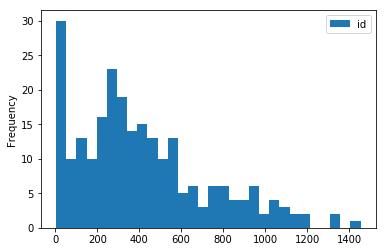

In [397]:
df_date.plot.hist(bins=30)

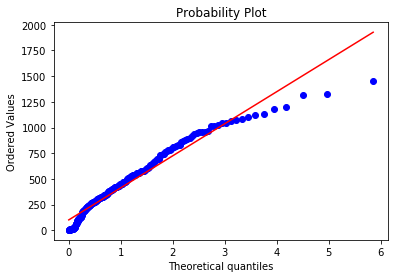

In [398]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(df_date.id, dist=stats.expon, plot=pylab)
pylab.show()

## Running the for loop on the news headlines

Load the data

In [399]:
nodes_retweets = df.loc[df.retweet_user_name.notna(),['user_name','retweet_user_name']]
df_RTs = nodes_retweets.groupby(['user_name','retweet_user_name']).agg({'retweet_user_name':'count'})
df_RTs = df_RTs.rename(columns={'retweet_user_name':'RT_count'})
df_RTs.reset_index(inplace=True)

Defining the list of headlines

In [270]:
news_headlines = [['macron', 'yellow vest', 'france', 'paris'],
                   ['michael','cohen'],
                   ['mueller','investigation'],
                   ['facebook','data','email','user','emails','documents','confidential'],
                   ['brexit']]
df_headlines = pd.DataFrame()
df_headlines['headline'] = news_headlines

In [400]:
news_headlines = [['yellow vest','yellowvest'],
                 ['protests'],
                 ['police'],
                 ['paris','macron']]

df_headlines = pd.DataFrame()
df_headlines['headline'] = news_headlines

In [401]:
df_headlines

,headline
0,"[yellow vest, yellowvest]"
1,[protests]
2,[police]
3,"[paris, macron]"


Run the for loop for each headline

In [402]:
net_nodes = []
net_speed = []
net_width = []
net_communities = []
net_modularity = []
net_patient_zero = []
social_networks = []

for headline in news_headlines:
    # subset dataframe by headline
    # subset only RTs
    df_temp = df[df.text.apply(lambda B: any([re.search(a,B.lower()) != None for a in headline]))]
    df_temp = df_temp[df_temp.retweet_user_name.notna()]
    # get the list of connected nodes
    nodes_retweets = df_temp.loc[df_temp.retweet_user_name.notna(),['user_name','retweet_user_name']]
    # get unique pairs of nodes and count to create weighted edges
    df_RTs = nodes_retweets.groupby(['user_name','retweet_user_name']).agg({'retweet_user_name':'count'})
    df_RTs = df_RTs.rename(columns={'retweet_user_name':'RT_count'})
    df_RTs.reset_index(inplace=True)
    # initialize the graph and add nodes + edges
    # get the biggest connected components
    N = nx.DiGraph()
    e = zip(df_RTs.user_name,df_RTs.retweet_user_name,df_RTs.RT_count.apply(lambda x: {'weight':x}))
    N.add_edges_from(e)
    N.remove_edges_from(N.selfloop_edges())
    N_subgraphs = sorted(nx.connected_component_subgraphs(N.to_undirected()), key=len, reverse=True)
    # find communities
    partition = community.best_partition(N_subgraphs[0].to_undirected())
    node_community = [partition.get(node) for node in N.nodes()]
    # speed data in the network
    df_temp_date = df_temp.groupby('date_day').agg({'id':'count'})

    # timestamps for each node
    # pd.merge(df_RTs[['user_name']],df_temp[['user_name','date_day']], how = 'left', on = 'user_name')
    
    S = N_subgraphs[0]
    pr = nx.pagerank(S)
    for n, d in S.nodes(data=True):
        d['pagerank'] = pr[n]
        d['community'] = partition[n]
    
    node_names = [node for node in S.nodes()]
    # find patient zero
    v0 = df_temp.loc[df_temp.retweet_user_name.isin(node_names)].sort_values('date').iloc[0,13]
    
    nx.write_gexf(S,'RT_big_component %s.gexf' % '-'.join(headline))
    print('----- %s -----' % headline)
    # shortest path of each node from the source (patient zero)
    width = nx.single_source_shortest_path_length(S,source=v0)
    
    social_networks.append(S)
    net_nodes.append(len(df_RTs))
    net_patient_zero.append(v0)
    net_speed.append(df_temp_date)
    net_width.append(width)
    net_communities.append(len(set(node_community)))
    net_modularity.append(community.modularity(partition,N_subgraphs[0].to_undirected()))

----- ['yellow vest', 'yellowvest'] -----
----- ['protests'] -----
----- ['police'] -----
----- ['paris', 'macron'] -----


In [403]:
df_headlines['size'] = net_nodes
df_headlines['patient_zero'] = net_patient_zero
df_headlines['communities'] = net_communities
df_headlines['modularity'] = net_modularity
df_headlines

,headline,size,patient_zero,communities,modularity
0,"[yellow vest, yellowvest]",35635,TheRebelTV,55,0.746118
1,[protests],32954,TheRebelTV,50,0.717753
2,[police],24574,JeSuisDog,54,0.695624
3,"[paris, macron]",52945,TheRebelTV,48,0.705620


In [404]:
df_spread = pd.DataFrame()
k = 0

for net in net_width:
    df_width = pd.DataFrame(list(net.items()))
    df_width.columns = ['user_name','source_path']
    df_width['headline'] = '-'.join(news_headlines[k])
    df_width = pd.merge(df,df_width,how='inner',on='user_name')
    df_spread = pd.concat([df_spread,df_width])
    k += 1

In [405]:
aggregation = {
    'id':'count',
    'source_path':'median'
}

In [406]:
df_spread_plot = df_spread.groupby(['headline','date_day']).agg(aggregation).reset_index()
df_spread_plot.head()

,headline,date_day,id,source_path
0,paris-macron,2018-11-30 04:00:00,8,1.0
1,paris-macron,2018-11-30 05:00:00,3,1.0
2,paris-macron,2018-11-30 06:00:00,3,1.0
3,paris-macron,2018-11-30 07:00:00,10,3.0
4,paris-macron,2018-11-30 08:00:00,12,5.0


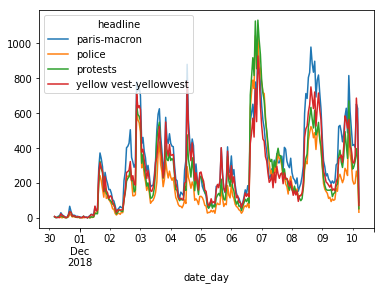

In [407]:
df_spread_plot.pivot(index='date_day',columns='headline',values='id').plot()
plt.savefig('headline1.pdf')

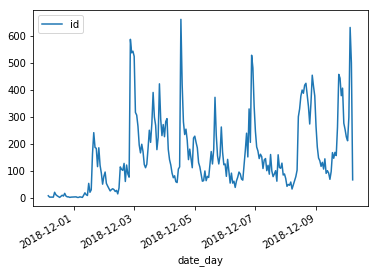

In [408]:
net_speed[0].plot(kind='line')

## Run loop for finding topics in communities